In [1]:
pip install nuscenes-devkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.1/313.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.8 MB/s eta 0:00:00
  Created wheel for matplotlib: filename=matplotlib-3.5.3-cp311-cp311-linux_x86_64.whl size=11116956 sha256=c4ece976859fd8a861b220f2e16c77bbf7ce976a768fa57e09c081178f6bda8e
  Stored in directory: /root/.cache/pip/wheels/5d/3b/87/b850f835f7a97bd28b0fb81fd73bdb17755122ea5ad71484f9
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=532ef945c4f7bf06bcd40c0043208b8c47612103eb6027216f4ca63b44291f8d
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.optim.lr_scheduler import StepLR

In [3]:
import numpy as np
np.Inf = np.inf  # Override deprecated np.Inf

In [4]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
batch_size = 16
epochs = 10
learning_rate = 0.0002
latent_dim = 100  # Noise vector size

In [6]:
!wget https://www.nuscenes.org/data/v1.0-mini.tgz
!mkdir -p /content/data/nuScenes
!tar -xvzf v1.0-mini.tgz -C /content/data/nuScenes


Streaming output truncated to the last 5000 lines.
sweeps/RADAR_FRONT_RIGHT/n008-2018-08-28-16-43-51-0400__RADAR_FRONT_RIGHT__1535489308753562.pcd
sweeps/RADAR_FRONT_RIGHT/n015-2018-10-02-10-50-40+0800__RADAR_FRONT_RIGHT__1538448763367118.pcd
sweeps/RADAR_FRONT_RIGHT/n008-2018-08-27-11-48-51-0400__RADAR_FRONT_RIGHT__1535385095712026.pcd
sweeps/RADAR_FRONT_RIGHT/n015-2018-11-21-19-38-26+0800__RADAR_FRONT_RIGHT__1542800373890829.pcd
sweeps/RADAR_FRONT_RIGHT/n015-2018-10-02-10-50-40+0800__RADAR_FRONT_RIGHT__1538448759670003.pcd
sweeps/RADAR_FRONT_RIGHT/n008-2018-08-30-15-16-55-0400__RADAR_FRONT_RIGHT__1535657108526513.pcd
sweeps/RADAR_FRONT_RIGHT/n015-2018-11-21-19-38-26+0800__RADAR_FRONT_RIGHT__1542800863656852.pcd
sweeps/RADAR_FRONT_RIGHT/n015-2018-11-21-19-38-26+0800__RADAR_FRONT_RIGHT__1542800991116832.pcd
sweeps/RADAR_FRONT_RIGHT/n015-2018-10-02-10-50-40+0800__RADAR_FRONT_RIGHT__1538448759815959.pcd
sweeps/RADAR_FRONT_RIGHT/n015-2018-11-21-19-38-26+0800__RADAR_FRONT_RIGHT__1542800379

In [7]:
import os
print("Files in dataset directory:", os.listdir("/content/data/nuScenes"))

Files in dataset directory: ['.v1.0-mini.txt', 'v1.0-mini', 'samples', 'sweeps', 'maps']


In [8]:
nusc = NuScenes(version='v1.0-mini', dataroot='./data/nuScenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.827 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [9]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [10]:
# Custom Dataset Class
class NuScenesDataset(Dataset):
    def __init__(self, nusc, transform=None):
        self.nusc = nusc
        self.transform = transform
        self.samples = [sample['token'] for sample in nusc.sample]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.nusc.get('sample', self.samples[idx])
        cam_front = self.nusc.get('sample_data', sample['data']['CAM_FRONT'])
        img_path = self.nusc.get_sample_data_path(cam_front['token'])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [11]:
# Create Dataset & DataLoader
dataset = NuScenesDataset(nusc, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 64 * 64 * 3), nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).view(-1, 3, 64, 64)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64 * 64 * 3, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Stability improvement
        )

    def forward(self, x):
        return self.model(x.view(-1, 64 * 64 * 3))


In [13]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [14]:
gen_losses, disc_losses = [], []

Epoch [1/10] - Generator Loss: 0.5791, Discriminator Loss: 1.3121
Epoch [2/10] - Generator Loss: 0.6068, Discriminator Loss: 1.3036
Epoch [3/10] - Generator Loss: 0.6896, Discriminator Loss: 1.1177
Epoch [4/10] - Generator Loss: 0.6920, Discriminator Loss: 1.1084
Epoch [5/10] - Generator Loss: 0.6922, Discriminator Loss: 1.1086
Epoch [6/10] - Generator Loss: 0.6918, Discriminator Loss: 1.1089
Epoch [7/10] - Generator Loss: 0.6919, Discriminator Loss: 1.1091
Epoch [8/10] - Generator Loss: 0.6911, Discriminator Loss: 1.1115
Epoch [9/10] - Generator Loss: 0.6906, Discriminator Loss: 1.1135
Epoch [10/10] - Generator Loss: 0.6915, Discriminator Loss: 1.1109


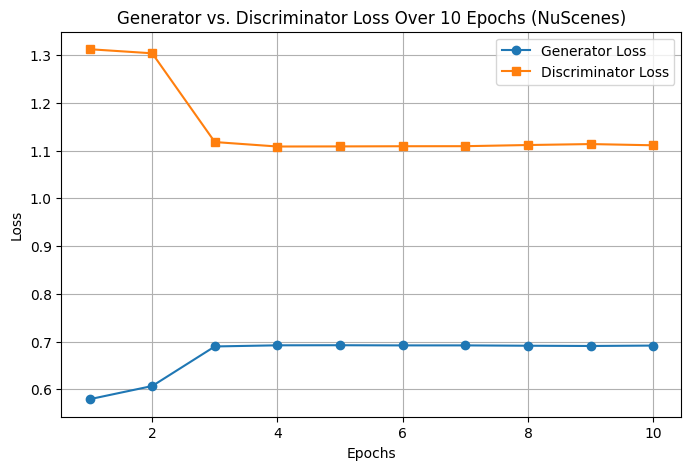

In [15]:
from torch.optim.lr_scheduler import StepLR

# Initialize learning rate schedulers
scheduler_G = StepLR(optimizer_G, step_size=5, gamma=0.5)  # Halve LR every 5 epochs
scheduler_D = StepLR(optimizer_D, step_size=5, gamma=0.5)

n_critic = 2  # Train generator twice per discriminator step

# Training Loop
gen_losses, disc_losses = [], []

for epoch in range(epochs):
    g_loss_total, d_loss_total = 0, 0
    batch_count = 0

    for real_imgs in dataloader:
        batch_count += 1
        real_imgs = real_imgs.to(device)
        noise = torch.randn(real_imgs.size(0), latent_dim, device=device)
        fake_imgs = generator(noise)

        # Train Discriminator
        real_labels = torch.full((real_imgs.size(0), 1), 0.9, device=device)  # Label Smoothing (was 1.0)
        fake_labels = torch.zeros(real_imgs.size(0), 1, device=device)

        real_preds = discriminator(real_imgs)
        fake_preds = discriminator(fake_imgs.detach())
        real_loss = F.binary_cross_entropy_with_logits(real_preds, real_labels)
        fake_loss = F.binary_cross_entropy_with_logits(fake_preds, fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        d_loss_total += d_loss.item()

        # Train Generator `n_critic` times per Discriminator step
        if batch_count % n_critic == 0:
            fake_preds = discriminator(fake_imgs)
            g_loss = F.binary_cross_entropy_with_logits(fake_preds, real_labels)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

            g_loss_total += g_loss.item()

    # Adjust learning rates
    scheduler_G.step()
    scheduler_D.step()

    gen_losses.append(g_loss_total / (batch_count / n_critic))
    disc_losses.append(d_loss_total / batch_count)

    print(f"Epoch [{epoch+1}/{epochs}] - Generator Loss: {gen_losses[-1]:.4f}, Discriminator Loss: {disc_losses[-1]:.4f}")


# Plot Loss Graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), gen_losses, label="Generator Loss", marker="o")
plt.plot(range(1, epochs + 1), disc_losses, label="Discriminator Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator vs. Discriminator Loss Over 10 Epochs (NuScenes)")
plt.legend()
plt.grid(True)
plt.show()
